In [1]:
from chiborg import jk_data, jk_hyp, jk_calc, tm_prior
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import cholesky
from more_itertools import powerset

Make many realizations of a $N = 2$ data set where one datum is unbiased (true mean = 1) and the other is biased by a value of 5. Set error bars equal to 1 and 2. Make a histogram and print sample covariance.

Sample covariance of data is 
 [[3.99669149e+00 1.08348367e-03]
 [1.08348367e-03 1.00179293e+00]]


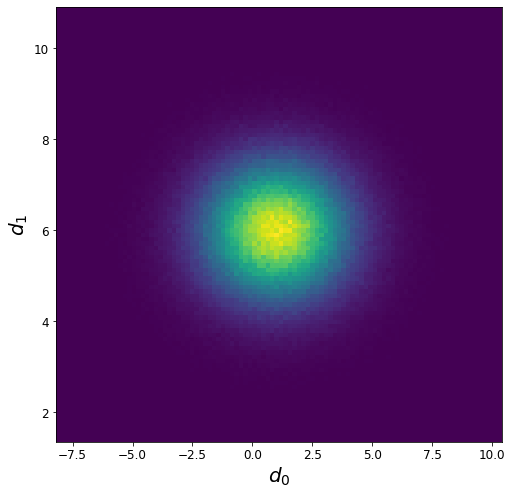

In [2]:
np.random.seed(47)
num_draw = int(1e6)

jkd = jk_data(sim_mean=np.ones(2), noise_cov=np.diag([4, 1]), sim_bias=np.array([0, 5]), num_dat=2,
              num_draw=num_draw)

def dat_hist_2d(jkd):

    plt.figure(figsize=(8, 8))

    _, _, _, _ = plt.hist2d(*jkd.data_draws.T, bins=100)
    plt.xlabel("$d_0$", fontsize=20)
    plt.ylabel("$d_1$", fontsize=20)
    plt.tick_params(labelsize=12)

dat_hist_2d(jkd)
print(f"Sample covariance of data is \n {np.cov(jkd.data_draws.T)}")

Make a similar data set, but make the bias for the second data point a random gaussian draw, simulating the marginal distribution over a bias prior corresponding to the gaussian draws. This will slightly broaden the biased dimension compared to the previous example ($d_1$).

Sample covariance of data is 
 [[ 3.99123266e+00 -1.41889017e-03]
 [-1.41889017e-03  1.99746949e+00]]


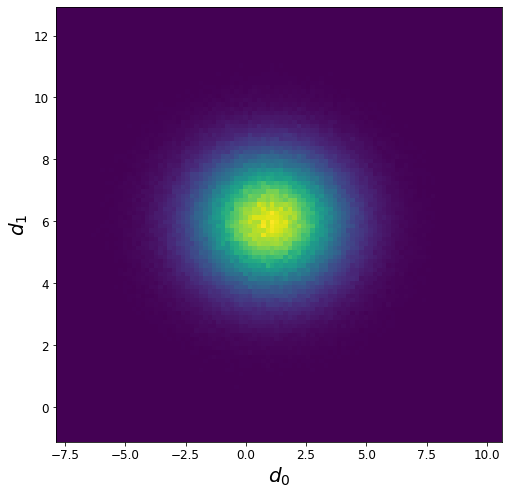

In [3]:
gauss_bias = np.random.multivariate_normal(mean=[0, 5], cov=[[0,0],[0, 1]], size=int(1e6))
jkd = jk_data(sim_mean=np.ones(2), noise_cov=np.diag([4,1]), sim_bias=gauss_bias, num_dat=2, num_draw=num_draw)

dat_hist_2d(jkd)
print(f"Sample covariance of data is \n {np.cov(jkd.data_draws.T)}")

Put all these realizations through the "diagonal hypothesis" set and analyze the performance. This begins by making a "jk_hyp" object, which contains all the information about the hypothesis sets, such as the prior parameters, number of hypotheses, etc. We then hand it to a "jk_calc" object to do all the probability calculations. We will look for $5\sigma$ biases.

In [32]:
tmp = tm_prior(norm.pdf, [-np.inf, np.inf], {'loc': 1, 'scale': 1e-2})
jkh = jk_hyp(jkd, 5 * np.array([2, 1]), np.ones(2), tmp=tmp)
print(jkh.bias_prior.mean)
print(jkh.bias_prior.cov)

[[ 0.  0.]
 [10.  0.]
 [ 0.  5.]
 [10.  5.]]
[[[0. 0.]
  [0. 0.]]

 [[1. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


This is a strong bias compared to the error bar $(5\sigma)$ on the dimension it exists in, so it should be extremely identifiable on average. Make a histogram of each proposed hypothesis according to the MAP rule. Results indicate a correct identification of the bias configuration about 96.9% of the time. There is mild bias misclassification about 1% of the time, and a false negative rate of about 2.2%.

[2.24800e-02 1.66000e-04 9.69208e-01 8.14600e-03]


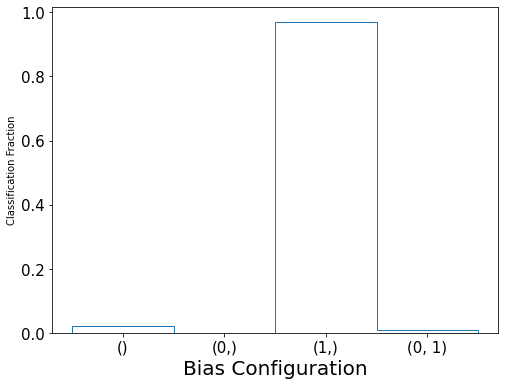

In [5]:
jkc = jk_calc(jkd, jkh)
MAP = np.argmax(jkc.post, axis=0) # axis 0 is the "hypothesis" axis

plt.figure(figsize=(8,6))
counts, _, _ = plt.hist(MAP, bins=np.arange(5), histtype="step", density=True)
print(counts)
xticks = np.arange(0.5, 4.5)
xticklabels = [item for item in powerset((0, 1))]
_, _ = plt.xticks(xticks, labels=xticklabels)
_ = plt.xlabel("Bias Configuration", fontsize=20)
_ = plt.ylabel("Classification Fraction")
plt.tick_params(labelsize=15)

As a consistency check, see if the semi-analytic and fully analytic results agree to within numerical precision. The sharply peaked histogram indicates they do.

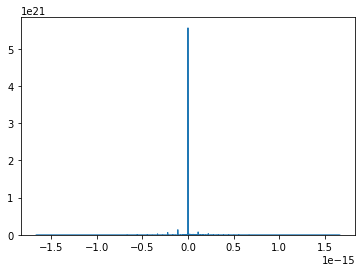

In [6]:
jkc_num = jk_calc(jkd, jkh, analytic=False)
_, _, _ = plt.hist((jkc.post - jkc_num.post).flatten(), bins="auto", histtype="step", density=True)

Integrate numerically over a nongaussian, bimodal, generally awkward prior

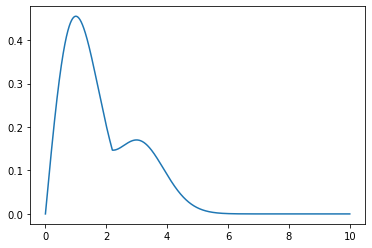

In [30]:
from scipy.stats import rayleigh

def nongauss(x, shift=2.2, mix=0.75, scale=1):
    """
    Superimpose a couple of shifted Rayleigh distributions to make something bimodal
    """
    fval = (mix * rayleigh.pdf(x, scale=scale) + (1 - mix) * rayleigh.pdf(x, loc=shift, scale=scale)) 
    return(fval)

x = np.linspace(0, 10, num=10000)
plt.plot(x, nongauss(x))

tmp = tm_prior(nongauss, [0, np.inf], {"shift": 2.2, "mix": 0.75, "scale": 1})
jkh_nongauss = jk_hyp(jkd, 5 * np.array([2, 1]), np.ones(2), tmp=tmp)
jkc_num = jk_calc(jkd, jkh_nongauss, analytic=False)
jkc = jk_calc(jkd, jkh, analytic=True)

Clearly still manages to identify the correct bias configuration despite a much broader and nongaussian prior. Histogram of correct hypothesis posterior shown in semilog to see the minute difference in the tails. 

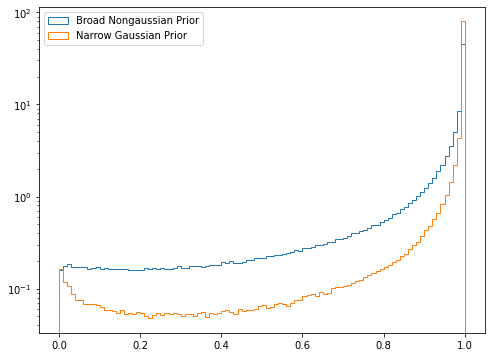

In [39]:

plt.figure(figsize=(8, 6))
_, _, _ = plt.hist(jkc_num.post[2], bins=np.linspace(0, 1, num=101), histtype='step', density=True, log=True,
                   label="Broad Nongaussian Prior")
_, _, _ = plt.hist(jkc.post[2], bins=np.linspace(0, 1, num=101), histtype='step', density=True, log=True,
                   label="Narrow Gaussian Prior")
plt.legend(loc="upper left")